In [12]:
import os
from dotenv import load_dotenv, find_dotenv
from os.path import join, dirname, basename, exists, isdir

### Load environmental variables from the project root directory ###
# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

# now you can get the variables using their names

# Check whether a network drive has been specified
DATABASE = os.environ.get("NETWORK_URL")
if DATABASE == 'None':
    pass
else:
    pass
    #mount network drive here

# set up directory pathsa
CURRENT_DIR = os.getcwd()
PROJ = dirname(dotenv_path) # project root directory

DATA = join(PROJ, 'data') #data directory
RAW_EXTERNAL = join(DATA, 'raw_external') # external data raw directory
RAW_INTERNAL = join(DATA, 'raw_internal') # internal data raw directory
INTERMEDIATE = join(DATA, 'intermediate') # intermediate data directory
FINAL = join(DATA, 'final') # final data directory

RESULTS = join(PROJ, 'results') # output directory
FIGURES = join(RESULTS, 'figures') # figure output directory
PICTURES = join(RESULTS, 'pictures') # picture output directory


# make folders specific for certain data
folder_name = ''
if folder_name != '':
    #make folders if they don't exist
    if not exists(join(RAW_EXTERNAL, folder_name)):
        os.makedirs(join(RAW_EXTERNAL, folder_name))

    if not exists(join(INTERMEDIATE, folder_name)):
        os.makedirs(join(INTERMEDIATE, folder_name))

    if not exists(join(FINAL, folder_name)):
        os.makedirs(join(FINAL, folder_name))


print('Standard variables loaded, you are good to go!')

Standard variables loaded, you are good to go!


In [13]:
import cobra
import os
import pandas as pd
import cameo
import wget
import ssl
from scipy.stats import pearsonr


#E. coli model:
#eColi_model = cameo.load_model("iML1515")


#E. coli model:
ssl._create_default_https_context = ssl._create_unverified_context
wget.download("https://raw.githubusercontent.com/BenjaSanchez/notebooks/master/e_coli_simulations/eciML1515.xml")
eColi_Model = cobra.io.read_sbml_model("eciML1515.xml")
os.remove("eciML1515.xml")


# proteomics data:
proteomics_dataset = f"{INTERMEDIATE}/proteomics/proteomics_concentrations.csv"


In [14]:
from collections import namedtuple
from cobra.medium.boundary_types import find_external_compartment
from cobra.io.dict import reaction_to_dict
import pandas as pd
import numpy as np

In [15]:
from simulations.modeling.driven import (
    adjust_fluxes2model,
    flexibilize_proteomics,
    minimize_distance,
)

In [16]:
def reset_real_proteomics(proteomics_dataset):
    '''loads set of proteomics data from the provided dataset file into dict of lists'''
    data = pd.read_csv(proteomics_dataset, index_col="UP")  # yeast
    data_dict = {}
    for i in range(0,data.shape[1], 3):
        uncertainty = data.iloc[:,i:i+3].std(axis=1)
        uncertainty_name = data.columns[i]+ "_uncertainty"
        data[uncertainty_name] = uncertainty
        data_dict[data.columns[i]] = [{'identifier':data.index[j], 'measurement':data.iloc[j,i], 'uncertainty':data[uncertainty_name][j] }\
         for j in range(0, len(data.iloc[:,i]))]
        data_dict[data.columns[i+1]] = [{'identifier':data.index[j], 'measurement':data.iloc[j,i+1], 'uncertainty':data[uncertainty_name][j] }\
         for j in range(0, len(data.iloc[:,i+1]))]
        data_dict[data.columns[i+2]] = [{'identifier':data.index[j], 'measurement':data.iloc[j,i+2], 'uncertainty':data[uncertainty_name][j] }\
         for j in range(0, len(data.iloc[:,i+2]))]
    return data_dict



In [17]:
proteomics_data = reset_real_proteomics(proteomics_dataset)

growth_rates = pd.read_csv(f"{RAW_INTERNAL}/proteomics/growth_conditions.csv")
growth_rates = growth_rates.drop(growth_rates.columns.difference(['Growth condition','Growth rate (h-1)', 'Stdev']), 1)
growth_rates = growth_rates.drop([0,1], axis=0)

In [18]:

def find_exchange_rxn(compound, model):
    exchange_reactions = [i for i in model.reactions if "EX" in i.id]
    compound_ex_rxn = [i for i in exchange_reactions if compound in i.name]
    compound_ex_rxn = [i for i in compound_ex_rxn if len(list(i._metabolites.keys())) == 1 \
                       & (list(i._metabolites.values())[0] == 1.0) \
                        & (list(i._metabolites.keys())[0].name == compound + " [extracellular space]")]
    return compound_ex_rxn

# minimal medium with pyruvate
pyruvate_growth_rate = list(growth_rates['Growth rate (h-1)'].loc[growth_rates['Growth condition'] == "Acetate"])[0]
model = eColi_Model.copy()
medium = model.medium
medium.pop("EX_glc__D_e_REV", None)

# find Pyruvate
ac_ex = find_exchange_rxn("Acetate", eColi_Model)
print(ac_ex)


medium[f'{ac_ex[0].id}'] = 10
model.medium = medium
# pyr_model.medium = minimal_medium(pyr_model).to_dict()
print(model.optimize())

[<Reaction EX_ac_e_REV at 0x135c3c390>]
<Solution 0.137 at 0x133e4e048>


In [19]:
# pyruvate sim

ac_model_1 = model
ac_model_2 = model
ac_model_3 = model

# first 
print("Number of proteins originally: ", len(proteomics_data["acetate"]))
growth_rate = {"measurement":float(list(growth_rates['Growth rate (h-1)'].loc[growth_rates['Growth condition'] == "Acetate"])[0]),\
    "uncertainty":float(list(growth_rates['Stdev'].loc[growth_rates['Growth condition'] == "Acetate"])[0])}
new_growth_rate, new_proteomics, warnings = flexibilize_proteomics(ac_model_1,  "BIOMASS_Ec_iML1515_core_75p37M", growth_rate, proteomics_data["acetate"], [])
print("Number of proteins incorporated: ", len(new_proteomics))

# first 
print("Number of proteins originally: ", len(proteomics_data["acetate1"]))
growth_rate = {"measurement":float(list(growth_rates['Growth rate (h-1)'].loc[growth_rates['Growth condition'] == "Acetate"])[0]),\
    "uncertainty":float(list(growth_rates['Stdev'].loc[growth_rates['Growth condition'] == "Acetate"])[0])}
new_growth_rate, new_proteomics, warnings = flexibilize_proteomics(ac_model_2,  "BIOMASS_Ec_iML1515_core_75p37M", growth_rate, proteomics_data["acetate1"], [])
print("Number of proteins incorporated: ", len(new_proteomics))

# first 
print("Number of proteins originally: ", len(proteomics_data["acetate2"]))
growth_rate = {"measurement":float(list(growth_rates['Growth rate (h-1)'].loc[growth_rates['Growth condition'] == "Acetate"])[0]),\
    "uncertainty":float(list(growth_rates['Stdev'].loc[growth_rates['Growth condition'] == "Acetate"])[0])}
new_growth_rate, new_proteomics, warnings = flexibilize_proteomics(ac_model_3,  "BIOMASS_Ec_iML1515_core_75p37M", growth_rate, proteomics_data["acetate2"], [])
print("Number of proteins incorporated: ", len(new_proteomics))


Number of proteins originally:  2058
Number of proteins incorporated:  2057
Number of proteins originally:  2058
Number of proteins incorporated:  2057
Number of proteins originally:  2058
Number of proteins incorporated:  2057


In [24]:


# usages of ac proteins

#solution = pyr_model.optimize()

# pyr model uages


def get_usages(prot_int_model):
    # get the usages of a model integrated with proteomics
    try:
        solution = cobra.flux_analysis.pfba(prot_int_model)
    except:
        solution = prot_int_model.optimize()
    abs_usages = pd.Series()
    perc_usages = pd.Series()
    for reaction in prot_int_model.reactions:
        if reaction.id.startswith("prot_"):
            prot_id = reaction.id.replace("prot_","")
            prot_id = prot_id.replace("_exchange","")
            abs_usage = solution.fluxes[reaction.id]
            abs_usages = abs_usages.append(pd.Series({prot_id:abs_usage}))
            perc_usage = solution.fluxes[reaction.id]/reaction.upper_bound*100
            perc_usages = perc_usages.append(pd.Series({prot_id:perc_usage}))
    return abs_usages, perc_usages

# 
abs_usages_1, perc_usages_1 = get_usages(ac_model_1)
abs_usages_2, perc_usages_2 = get_usages(ac_model_2)
abs_usages_3, perc_usages_3 = get_usages(ac_model_3)

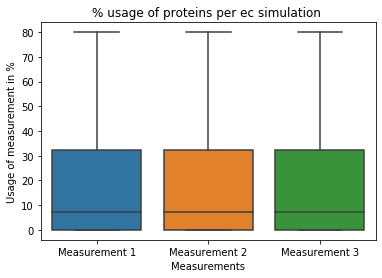

In [25]:
import numpy as np; np.random.seed(42)
import matplotlib.pyplot as plt
import seaborn as sns

df = perc_usages_1.to_frame()
df["perc_usages_2"] = perc_usages_2
df["perc_usages_3"] = perc_usages_3
df.columns = ["Measurement 1", "Measurement 2", "Measurement 3"]

sns.boxplot(x="variable", y="value", data=pd.melt(df[(df > 0) & (df < 100)]))
plt.xlabel('Measurements')
plt.ylabel('Usage of measurement in %')
plt.title('% usage of proteins per ec simulation ')
plt.savefig(f'{FIGURES}/ec_incorporation_perc_usage_box_pyr')
plt.show()



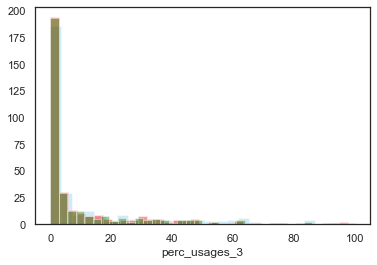

In [23]:
#df['pct'] = df['Location'].div(df.groupby('Hour')['Location'].transform('sum'))
#g = sns.FacetGrid(df, row="pct", hue="pct", aspect=15, height=.5, palette=pal)

perc_incorporation_pyr = pd.melt(df[(df > 0) & (df < 100)])
 
# Method 1: on the same Axis
sns.distplot( df[(df > 0) & (df < 100)].iloc[:,0] , color="skyblue", label="1", kde=False)
sns.distplot( df[(df > 0) & (df < 100)].iloc[:,1], color="red", label="2", kde=False)
sns.distplot( df[(df > 0) & (df < 100)].iloc[:,2], color="green", label="3", kde=False)


/Library/Python/3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike



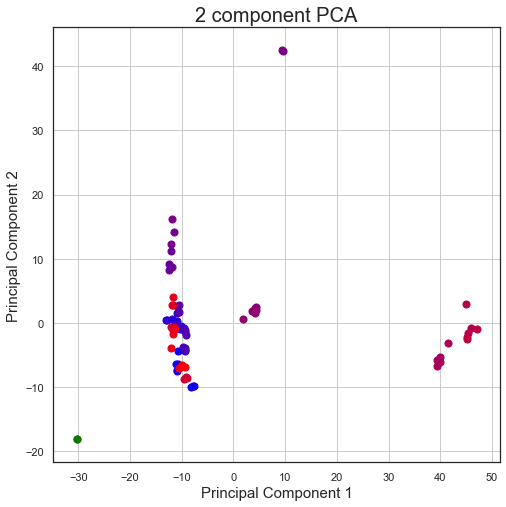

In [62]:
from sklearn.preprocessing import StandardScaler

# standardize data for pca 
# #features = ['sepal length', 'sepal width', 'petal length', 'petal width']# Separating out the features
pca_df_all_proteomics_and_pyr = pd.read_csv(proteomics_dataset, index_col="UP").loc[df.index,:]
pca_df_all_proteomics_and_pyr['pyr_1'] = abs_usages_1
pca_df_all_proteomics_and_pyr = pca_df_all_proteomics_and_pyr.T.dropna(axis='columns')
x = pca_df_all_proteomics_and_pyr.values
x = StandardScaler().fit_transform(x)

# run pca
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf.index = pca_df_all_proteomics_and_pyr.index

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA with zero values', fontsize = 20)

amount = len(principalDf.index)
for i in range(amount):
    c = [float(i)/float(amount), 0.0, float(amount-i)/float(amount)] #R,G,B
    ax.scatter(principalDf.loc[principalDf.index[i], 'principal component 1']
           , principalDf.loc[principalDf.index[i], 'principal component 2']
           , color = c 
           , s = 50)
ax.scatter(principalDf.loc["pyr_1", 'principal component 1']
           , principalDf.loc[principalDf.index[i], 'principal component 2']
           , color = "green"
           , s = 50)


#ax.legend(pca_df_all_proteomics_and_pyr.index)
ax.grid()
plt.savefig(f'{FIGURES}/')


/Library/Python/3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike



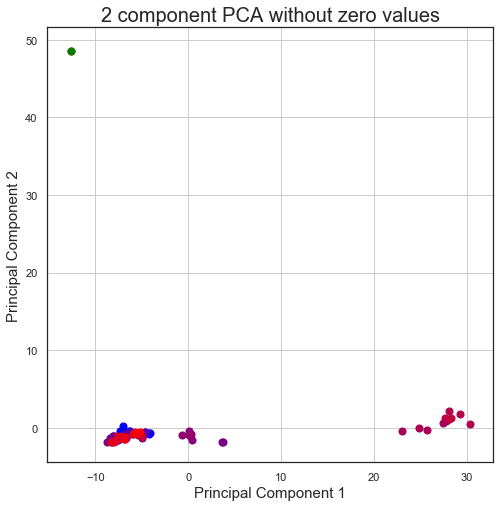

In [63]:
# standardize data for pca 
# #features = ['sepal length', 'sepal width', 'petal length', 'petal width']# Separating out the features
pca_df_all_proteomics_and_pyr = pd.read_csv(proteomics_dataset, index_col="UP").loc[df.index,:]
pca_df_all_proteomics_and_pyr['pyr_1'] = abs_usages_1
pca_df_all_proteomics_and_pyr = pca_df_all_proteomics_and_pyr[pca_df_all_proteomics_and_pyr['pyr_1'] > 0]
pca_df_all_proteomics_and_pyr = pca_df_all_proteomics_and_pyr.T.dropna(axis='columns')
x = pca_df_all_proteomics_and_pyr.values
x = StandardScaler().fit_transform(x)

# run pca
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf.index = pca_df_all_proteomics_and_pyr.index

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA without zero values', fontsize = 20)

amount = len(principalDf.index)
for i in range(amount):
    c = [float(i)/float(amount), 0.0, float(amount-i)/float(amount)] #R,G,B
    ax.scatter(principalDf.loc[principalDf.index[i], 'principal component 1']
           , principalDf.loc[principalDf.index[i], 'principal component 2']
           , color = c 
           , s = 50)
ax.scatter(principalDf.loc["pyr_1", 'principal component 1']
           , principalDf.loc[principalDf.index[i], 'principal component 2']
           , color = "green"
           , s = 50)

ax.grid()

In [26]:
pd.DataFrame({'ac_1':abs_usages_1, 'ac_2':abs_usages_2, 'ac_3':abs_usages_3}).to_csv(f'{INTERMEDIATE}/proteomics/acetate_usages.csv')
